# Analysis of M66 (NGC 3627) with JWST

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import shutil

from astroquery.mast import Observations
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandradir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

## Notes

**Photometry**: <br>
- links for [conversion](https://jwst-docs.stsci.edu/jwst-near-infrared-camera#gsc.tab=0) and [filters](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters#gsc.tab=0).


**Misc**
- Always keep in mind that coordinates are flipped in a fits image

## Querying JWST Data

In [4]:
%%time

filters = ["F150W", "F200W", "F150W", "F277W", "F444W"
           "F300M", "F335M", "F360M",
           "F187N", "F212N"]
proposal_id = [2107, 4793]
print("Finding observations for JWST images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="JWST",
                                        filters=filters, proposal_id=proposal_id,
                                        instrument_name="NIRCAM/IMAGE")
print("Done")

Finding observations for JWST images...
Done
CPU times: user 35.2 ms, sys: 7.05 ms, total: 42.3 ms
Wall time: 30.4 s


In [5]:
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str7,str12,str4,str5,str8,str8,str84,str36,float64,float64,str5,str15,int64,float64,float64,float64,float64,float64,str105,float64,str4,str2,int64,str115,str62,str63,str6,bool,float64,str9,str9,str9,float64
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f150w,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.7612082816,60665.776121145835,858.9439999999997,1331.0,1668.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072869366 12.963631618 170.03292137 12.978889968 170.048625314 13.017934287 170.088578625 13.002673538,mast:JWST/product/jw04793-o011_t011_nircam_clear-f150w_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f150w_i2d.fits,PUBLIC,False,nan,234389769,793836430,793836430,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F360M,INFRARED,NGC-3627,Galaxy; Spiral galaxies,jw02107-o029_t011_nircam_clear-f360m,170.06010458333333,12.983758333333332,image,"Lee, Janice",3,59957.60078729606,59957.65987877315,858.9439999999996,3427.0,3814.0,A JWST-HST-VLT/MUSE-ALMA Treasury of Star Formation in Nearby Galaxies,59960.26373838,2107,GO,--,POLYGON 170.064025948 12.942315942 170.02645268 12.956365371 170.052701715 13.023033291 170.090283579 13.008980093,mast:JWST/product/jw02107-o029_t011_nircam_clear-f360m_i2d.jpg,mast:JWST/product/jw02107-o029_t011_nircam_clear-f360m_i2d.fits,PUBLIC,False,nan,109508031,747060856,747060856,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F200W,INFRARED,NGC-3627,Galaxy; Spiral galaxies,jw02107-o029_t011_nircam_clear-f200w,170.06010458333333,12.983758333333332,image,"Lee, Janice",3,59957.600786555326,59957.68150171296,2405.0399999999995,1755.0,2226.0,A JWST-HST-VLT/MUSE-ALMA Treasury of Star Formation in Nearby Galaxies,59960.26373838,2107,GO,--,POLYGON 170.064228842 12.942098631 170.025897491 12.956670458 170.052784974 13.023840005 170.09112511 13.009264239,mast:JWST/product/jw02107-o029_t011_nircam_clear-f200w_i2d.jpg,mast:JWST/product/jw02107-o029_t011_nircam_clear-f200w_i2d.fits,PUBLIC,False,nan,109507984,747060759,747060759,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F335M,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f335m,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.70665361806,60665.730638229164,1631.992,3177.0,3538.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072667126 12.963856686 170.033312403 12.978642692 170.048534577 13.017118324 170.08789449 13.002330028,mast:JWST/product/jw04793-o011_t011_nircam_clear-f335m_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f335m_i2d.fits,PUBLIC,False,nan,234389745,793836338,793836338,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F212N,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f212n,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.7343661875,60665.75835078704,1631.992,2109.0,2134.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072869214 12.963632641 170.032918963 12.978891781 170.048622441 13.017935126 170.088578008 13.002673587,mast:JWST/product/jw04793-o011_t011_nircam_clear-f212n_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f212n_i2d.fits,P

In [6]:
# The code is downloading many extra files that are not needed. 
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)

data_prod = ['I2D']       # other options are ['FLT','DRC','DRZ']
data_type = ['CALJWST']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")

 This may take several minutes... 



obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str69,str9,str28,str11,str1,str7,str6,str4,str51,int64,str9,str6,int64,str5
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2107,jw02107029002_gs-acq1_2023013152509_stream.fits,408960,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2107,jw02107029002_gs-acq1_2023013152509_uncal.fits,420480,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.17.1,2107,jw02107029002_gs-acq1_2023013152509_cal.fits,1284480,109507984,PUBLIC,2,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,2107,jw02107029002_gs-acq2_2023013152511_stream.fits,37440,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_uncal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,2107,jw02107029002_gs-acq2_2023013152511_uncal.fits,48960,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_cal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,1.17.1,2107,jw02107029002_gs-acq2_2023013152511_cal.fits,106560,109507984,PUBLIC,2,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153039_stream.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153039_stream.fits,4731840,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153039_uncal.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153039_uncal.fits,5964480,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153258_stream.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153258_stream.fits,1589760,109507984,PUBLIC,1,F200W


Since the above code is downloading additional files that are not required, I am manually downloading data from this [link](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table) for M66. 

The filters that I am using are: 360m, 335m, 300m, 200w

# Photometry

In [2]:
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

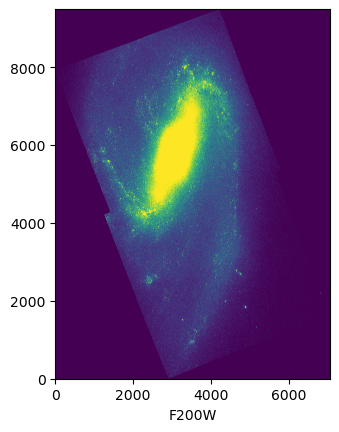

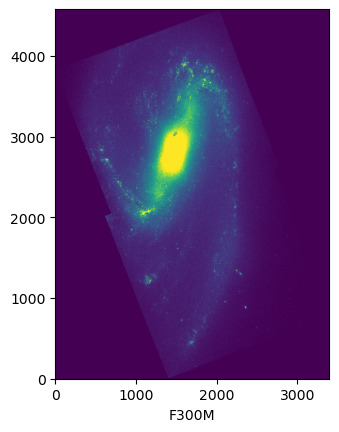

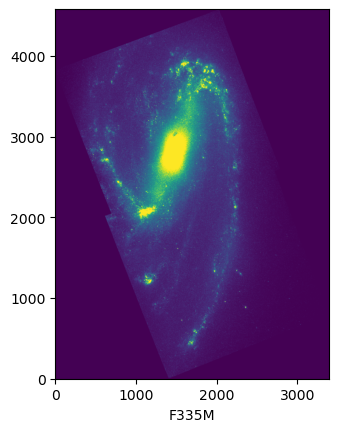

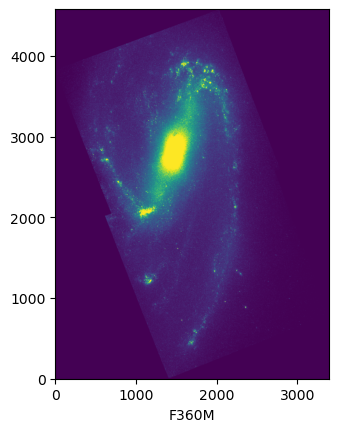

In [24]:
images = {
          "F200W" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits",
          "F300M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits",
          "F335M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits",
          "F360M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"
}

for filter in images:
    hdu = fits.open(images[filter])
    data = hdu['sci'].data
    plt.imshow(data, origin='lower', vmin=0, vmax=10)
    plt.xlabel(filter)
    plt.show()

## F200W

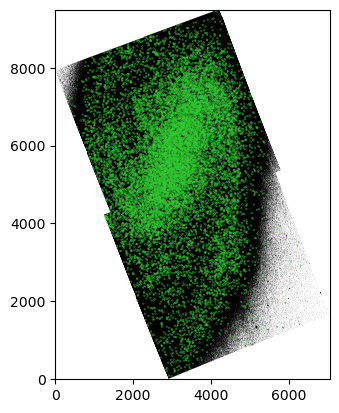

In [37]:
fwhm = 0.4
conversion = 0.031 # arcsec/pix for short wavelength filters for JWST NIRCAM
data = fits.getdata(f200w)

mean, median, std = sigma_clipped_stats(data, sigma=5)

daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=5*std)
objects = daofind(data)
positions = np.transpose((objects["xcentroid"],
                          objects["ycentroid"]))
apertures = CircularAperture(positions, r=5)

plt.imshow(data, cmap="gray_r", origin='lower',
          vmin=0, vmax=0.3)
apertures.plot(color='limegreen', lw=1)
plt.show()

In [52]:
%matplotlib inline

In [108]:
0.15 / conversion

4.838709677419355

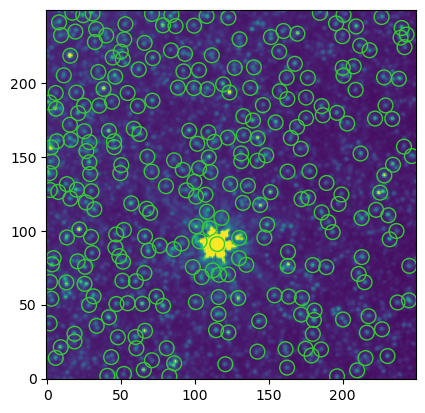

In [114]:
zoom1 = hdu_data[1900:2150, 4250:4500]

fwhm = 0.10 * 2  # 14 found through ds9
conversion = 0.031
mean, median, std = sigma_clipped_stats(zoom1, sigma=5)
daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=5*std)
objects = daofind(zoom1)
positions = np.transpose((objects["xcentroid"],
                          objects["ycentroid"]))
apertures = CircularAperture(positions, r=5)

plt.imshow(zoom1, cmap='viridis', vmin=0, vmax=10, origin='lower')
apertures.plot(color='limegreen', lw=1)
plt.show()

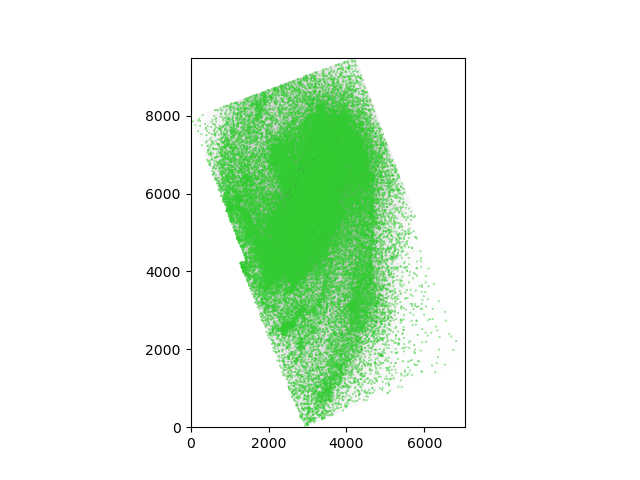

In [147]:
%matplotlib widget
fwhm = 0.10 * 2 # 0.14 found through ds9, 0.10 found through experimentation
conversion = 0.031 # arcsec/pix for short wavelength filters for JWST NIRCAM
data = fits.getdata(f200w)

mean, median, std = sigma_clipped_stats(data, sigma=5)

daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=5*std)
objects = daofind(data)
positions = np.transpose((objects["xcentroid"],
                          objects["ycentroid"]))
apertures = CircularAperture(positions, r=5)

plt.imshow(data, cmap="gray_r", origin='lower',
          vmin=0, vmax=10)
apertures.plot(color='limegreen', lw=1)
plt.show()

0.09999999999999999
6.451612903225807


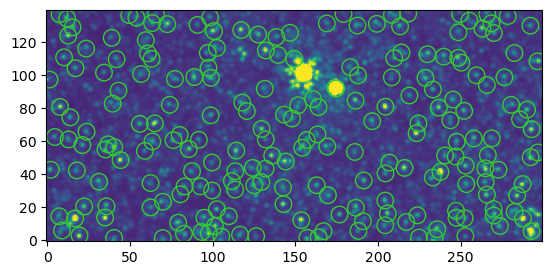

In [146]:
# x-axis  3100-3200
# y-axis 3240- 3380
%matplotlib inline

zoom2 = hdu_data[3240:3380, 3000:3300]

fwhm = 0.10 * 2  # 14 found through ds9
conversion = 0.031
print(0.09+0.01)
print(fwhm/conversion)
mean, median, std = sigma_clipped_stats(zoom2, sigma=5)
daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=5*std)
objects = daofind(zoom2)
positions = np.transpose((objects["xcentroid"],
                          objects["ycentroid"]))
apertures = CircularAperture(positions, r=5)

plt.imshow(zoom2, cmap='viridis', vmin=0, vmax=10, origin='lower')
apertures.plot(color='limegreen', lw=1)
plt.show()

In [4]:
def find_objects(data_file, fwhm, threshold=None, sigma=5, conversion=0.031, radius=5, cmap='viridis', vmin=0, vmax=0.3, aperture_color='limegreen'):
    """
    Find objects in an image using the DAOFind algorithm and then plot apertures around the objects. 
    
    PARAMETERS"""
    data = fits.getdata(data_file)
    mean, median, std = sigma_clipped_stats(data, sigma=5)
    daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=5*std)
    objects = daofind(data)
    positions = np.transpose((objects["xcentroid"], objects["ycentroid"]))

    # Create apertures around sources
    apertures = CircularAperture(positions, r=radius)
    plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    apertures.plot(color=aperture_color)
    plt.show()
    
    return positions

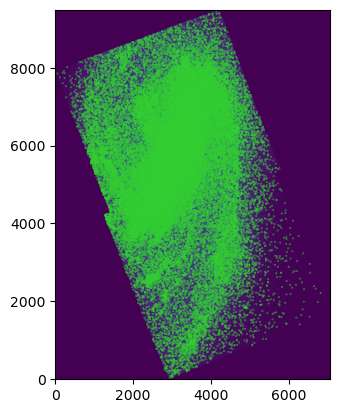

array([[2939.03315286,   23.19328328],
       [2995.00786022,   48.14812742],
       [3014.2607533 ,   50.17128764],
       ...,
       [4215.99119844, 9392.06810127],
       [4211.75378093, 9396.15648842],
       [4135.77476733, 9450.91118819]], shape=(54624, 2))

In [5]:
fwhm = 0.10 * 2
conversion = 0.031
sigma = 5

objects = find_objects(f200w, fwhm=fwhm, vmin=0, vmax=10)
objects

In [16]:
data = fits.getdata(f200w)
mean, median, std = sigma_clipped_stats(data, sigma=5)
daofind = DAOStarFinder(fwhm=fwhm/conversion, threshold=5*std)
objects = daofind(data)
positions = np.transpose((objects["xcentroid"], objects["ycentroid"]))
positions

apertures = CircularAperture(positions, r=radius)
plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
apertures.plot(color=aperture_color)
plt.show()

NameError: name 'radius' is not defined